# ANÁLISIS DEL DATASET NYC AIRBNB.

## 1-PREPARACIÓN INICIAL

### 1.1-Inicialización de librerías.

In [ ]:

# Liibrerías básicas para análisis de datos y Machine Learning.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Librería de Scikit-Learn para la clase OutlierToNaN
from sklearn.base import BaseEstimator, TransformerMixin

# Librerías de Scikit-Learn para preprocesado, modelado y evaluación.
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import SelectKBest, f_regression, chi2
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix

# Librerías para modelos de regresión y clasificación.
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC

# Librerías para vectorización de textos.
from sklearn.feature_extraction.text import TfidfVectorizer

# Librerías de TensorFlow-Keras para clasificación multiclase en Deep Learning.
import tensorflow as tf
from tensorflow import keras
#from keras.models import Sequential
#from keras.layers import Dense, Dropout

# Librería SMOTE para el balanceo de clases.
from imblearn.over_sampling import SMOTE


### 1.2-Carga de datos.

In [ ]:
# Archivo fuente de datos.
file = 'E:/Documentos/Josi/Formaciones/HackABoss _NTT Data-Data_Science_Bootcamp/GitHub-Ejercicios_Bootcamp_Data_Science/Data-Science-Bootcamp/Ejercicios_Evaluados/Modulo_5/Data/airbnb_nyc_clean.csv'

# Carga del archivo fuente y generación del DataFrame.
df_raw = pd.read_csv(file)

Dado que en el enunciado del ejercicio se indica que se debe eliminar las columnas 'name', 'id', 'host_id', 'host_name', se hace una copia del DataFrame original (por seguridad, para trabajar con él) y se procede a eliminar las columnas indicadas.

In [ ]:
df = df_raw.copy()
df.drop(['name','id', 'host_id', 'host_name'], axis=1, inplace=True) 

### 1.3-Funciones auxiliares.

In [71]:

class OutlierToNaN(BaseEstimator, TransformerMixin):
    """
    Reemplaza valores outliers por NaN usando el método IQR de Tukey
    Funciona con DataFrames de pandas o arrays NumPy
    """
    def __init__(self, factor=1.5):
        self.factor = factor
        
    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.is_df_ = True
            self.numeric_cols_ = X.select_dtypes(include=[np.number]).columns
            Q1 = X[self.numeric_cols_].quantile(0.25)
            Q3 = X[self.numeric_cols_].quantile(0.75)
        else:
            self.is_df_ = False
            Q1 = np.percentile(X, 25, axis=0)
            Q3 = np.percentile(X, 75, axis=0)
        
        IQR = Q3 - Q1
        self.lower_bounds_ = Q1 - (self.factor * IQR)
        self.upper_bounds_ = Q3 + (self.factor * IQR)
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        if self.is_df_:
            numeric_data = X_copy[self.numeric_cols_]
            outlier_mask = (numeric_data < self.lower_bounds_) | (numeric_data > self.upper_bounds_)
            X_copy[self.numeric_cols_] = numeric_data.mask(outlier_mask, np.nan)
            return X_copy
        else:
            outlier_mask = (X_copy < self.lower_bounds_) | (X_copy > self.upper_bounds_)
            X_copy[outlier_mask] = np.nan
            return X_copy

""" # Función para el análisis preliminar del DataFrame.
def df_analisis(df):
    print('Información del DataFrame:')
    print(df.info())
    print('*' * 10, end="\n")
    print('Descripción del DataFrame:')
    print(df.describe())
    print('Primeras 5 filas del DataFrame:')
    print(df.head())
    print('Últimas 5 filas del DataFrame:')
    print(df.tail())
    print('Valores nulos del DataFrame:')
    print(df.isna().sum()) """
    
# Función para recoger todos los valores estadísticos en un DataFrame.
# Entrada: DataFrame de Pandas.
# Salida: DataFrame de Pandas con los valores estadísticos de cada columna.
def df_estadisticas(df):
    
    # Se inicializan las listas auxiliares.
    dict_columnas = {}
    media_list = []
    mediana_list = []
    moda_list = []
    std_list = []
    var_list = []
    min_list = []
    max_list = []
    q1_list = []
    q2_list = []
    q3_list = []
    iqr_list = []
    asimetria_list = []
    curtosis_list = []
    
    for col in df.columns:                              # Se recorren las columnas del DataFrame.
        if pd.api.types.is_numeric_dtype(df[col]):      # Se comprueba si la columna contiene datos numéricos.
            if df[col].dtype == bool:                   # Se comprueba si la columna contiene datos booleanos.
                col_data = df[col].astype(int)          # Si es booleano, se convierte a entero para que no de problemas al calcular el IQR.
            else:
                col_data = df[col]
            # Se calculan los valores estadísticos de la columna de tipo numérico.
            media_list.append(col_data.mean())
            mediana_list.append(col_data.median())
            moda_list.append(col_data.mode()[0])
            std_list.append(col_data.std())
            var_list.append(col_data.var())
            min_list.append(col_data.min())
            max_list.append(col_data.max())
            q1_list.append(col_data.quantile(0.25))
            q2_list.append(col_data.quantile(0.5))
            q3_list.append(col_data.quantile(0.75))
            iqr_list.append(col_data.quantile(0.75) - col_data.quantile(0.25))
            asimetria_list.append(col_data.skew())
            curtosis_list.append(col_data.kurt())
        else:
            # Al tratarse de una columna de tipo categórico, se rellenan todos los valores a 'nan', excepto la moda.
            media_list.append(np.nan)
            mediana_list.append(np.nan)
            moda_list.append(df[col].mode()[0])
            std_list.append(np.nan)
            var_list.append(np.nan)
            min_list.append(np.nan)
            max_list.append(np.nan)
            q1_list.append(np.nan)
            q2_list.append(np.nan)
            q3_list.append(np.nan)
            iqr_list.append(np.nan)
            asimetria_list.append(np.nan)
            curtosis_list.append(np.nan)
            
    # Se genera el diccionario que contiene a las columnas del DataFrame.
    dict_columnas = {'mean': media_list, 'median': mediana_list, 'mode': moda_list, 'std': std_list, 'var': var_list, 'min': min_list, 'max': max_list, 'q1': q1_list, 'q2': q2_list, 'q3': q3_list, 'iqr': iqr_list, 'skew': asimetria_list, 'kurt': curtosis_list}
    
    # Se genera el DataFrame con las columnas generadas anteriormente, y se añaden como índices las columnas del DataFrame original.
    df_valores = pd.DataFrame(dict_columnas, index=df.columns)
    
    return df_valores

# Función que representa gráficas, en función de los tipos de datos de las columnas del DataFrame, para su análisis univariante en la fase EDA de un DataSet.
# Entrada: DataFrame de Pandas, conteniendo los valores a analizar. Nombre de la columna del DataFrame a representar.
# Salida: representación gráfica mediante Histogramas y Boxplot, para las variables numéricas, y gráficos de barras para la variables categóricas.
def graficos_EDA_univariante(df, col, colores='blue', anchura=12, altura=12, texto_x=10, rotacion_x=0):
    
    if pd.api.types.is_numeric_dtype(df[col]) and df[col].dtype != bool:
              
        plt.figure(figsize=(anchura,altura))
        
        plt.subplot(2,1,1)
        sns.histplot(
            df[col],
            bins=30,
            color=colores,
            kde=True,
            alpha=0.3
        )
        plt.title(f'Histograma de la columna {col}.')
        plt.xlabel(col)
        plt.ylabel('Frecuencia')
        plt.xticks(fontsize=texto_x, rotation=rotacion_x)
        plt.axvline(df[col].mean(), color='black', linestyle='--', label=f'Media: {df[col].mean():.2f}') # media.
        plt.axvline(df[col].median(), color='blue', linestyle='dotted', label=f'Mediana: {df[col].median():.2f}') # mediana.
        plt.axvline(df[col].quantile(0.25), color='yellow', linestyle='-.', label=f'Q1: {df[col].quantile(0.25):.2f}') # Q1.
        plt.axvline(df[col].quantile(0.75), color='red', linestyle='-.', label=f'Q3: {df[col].quantile(0.75):.2f}') # Q3.
        plt.legend()
        plt.grid()
        
        plt.subplot(2,1,2)
        sns.boxplot(data= df,
                    y= col,
                    showmeans=True,
                    label='Media'
        )
        plt.title(f'Distribución de frecuencias de la columna {col}')
        plt.xlabel('Titulo X')
        plt.ylabel('Precio (€)')
        plt.show();  
        
    else:
        if df[col].dtype == bool:                   # Se comprueba si la columna contiene datos booleanos. Si es así, se va a representar como datos categóricos.
            col_data = df[col].astype(str)          # Si es booleano, se convierte a texto para que no de problemas al representar la gráfica.
        else:
            col_data = df[col]
        plt.figure(figsize=(anchura, altura))
        sns.countplot(df, x=col, color=colores, order=sorted(col_data.unique())) # Se filtran los grados que sí tienen presencia, de todos los valores que puede tener, en la columna 'color'.
        plt.title(f'Boxplot de la columna "{col}"')
        plt.xlabel(f'Valores de la columna "{col}".')
        plt.ylabel(f'Frecuencia')
        plt.xticks(fontsize=texto_x, rotation=rotacion_x)
        plt.grid(axis='y')
        plt.show();   

# Función para presentar los principales valores estadísticos de una columna determinada del DataFrame.
# Entrada: DataFrame de Pandas y columna del DataFrame (la columna debe existir en el DataFrame).
# Salida: Diccionario con los valores estadísticos de la columna. Se imprimen los valores por consola
def analisis_columna(df, col, colores='blue', anchura=12, altura=12, texto_x=10, rotacion_x=0):
    cabecera = '*' * 10 + f' DATOS DE LA COLUMNA "{col}" ' + '*' * 10
    print(cabecera, "\n")
    print('Tipo de datos:', df[col].dtype, "\n")
    print('Valores nulos:', df[col].isna().sum(), "\n")
    print('Valores únicos:', df[col].nunique(), "\n")
    print('Frecuencia de valores:', df[col].value_counts(), "\n")
    
    if  df[col].isin([0, 0.0, '0', '0.0']).any():  # Se comprueba si la columna contiene valores 0.
        print(f'La columna "{col}" tiene uno o varios valores 0.', "\n")
    else:
        print(f'La columna "{col}" no tiene valores 0.', "\n")
    if np.isin(df.dtypes[col], ['b', 'O', 'S', 'U']).any(): # Se comprueba si la columna (Serie de Pandas) contiene valores categóricos.
        moda_col = df[col].mode()[0]
        dict_valores = {'Moda': moda_col}
        print(f'Moda: {moda_col}')
    elif pd.api.types.is_numeric_dtype(df[col]):    # La columna (Serie de Pandas) contiene valores numéricos
        if df[col].dtype == bool:                   # Se comprueba si la columna contiene datos booleanos.
            col_data = df[col].astype(int)          # Si es booleano, se convierte a entero para que no de problemas al calcular el IQR.
        else:
            col_data = df[col]

        media_col = col_data.mean()
        print(f'Media: {media_col}')
        mediana_col = col_data.median()
        print(f'Mediana: {mediana_col}')
        moda_col = col_data.mode()[0]
        print(f'Moda: {moda_col}')
        std_col = col_data.std()
        print(f'Desviación estándar: {std_col}')
        var_col = col_data.var()
        print(f'Varianza: {var_col}')
        min_col = col_data.min()
        print(f'Mínimo: {min_col}')
        max_col = col_data.max()
        print(f'Máximo: {max_col}')
        q1_col = col_data.quantile(0.25)
        print(f'Percentil 25 (Q1): {q1_col}')
        q2_col = col_data.quantile(0.5)
        print(f'Percentil 50 (Q2): {q2_col}')
        q3_col = col_data.quantile(0.75)
        print(f'Percentil 75 (Q3): {q3_col}')
        iqr_col = q3_col - q1_col
        print(f'Rango intercuartílico (IQR): {iqr_col}')
        asimetria_col = col_data.skew()
        print(f'Asimetría: {asimetria_col}')
        curtosis_col = col_data.kurt()
        print(f'Curtosis: {curtosis_col}')
        dict_valores = {'Media': media_col, 'Mediana': mediana_col, 'Moda': moda_col, 'Desviación': std_col, 'Varianza': var_col, 'Mínimo': min_col, 'Máximo': max_col, 'Q1': q1_col, 'Q2': q2_col, 'Q3': q3_col, 'IQR': iqr_col, 'Asimetría': asimetria_col, 'Curtosis': curtosis_col}
    
    pie = ' FIN '.center(len(cabecera), '*')
    print("\n", pie, end="\n")
    
    graficos_EDA_univariante(df, col, colores, anchura, altura, texto_x, rotacion_x) # Se representa la gráfica correspondiente a la columna analizada.
    
    return dict_valores  


## 2-EXPLORATORY DATA ANALYSIS (EDA).

### 2.1-Análisis preliminar.

#### 2.1.1-Inspección previa de los datos.

Como pasos previos:
* Se crea un nuevo DataFrame conteniendo todos los valores estadísticos más importantes de cada columna del DataFrame original.
* Se crean sendas listas conteniendo, por un lado, las columnas con valores numéricos; y por otro lado, las columnas con valores categóricos.

In [ ]:
# Se crea el DataFrame con los valores estadísticos de cada columna.
df_estadistica = df_estadisticas(df)
df_estadistica

In [ ]:
# Se crea una lista conteniendo los nombre de las columnas con valores numéricos.
col_num = df.select_dtypes(include=[np.number]).columns.tolist()
print(col_num)

In [ ]:
# Se crea una lista conteniendo los nombre de las columnas con valores categóricos.
col_cat = df.select_dtypes(exclude=[np.number]).columns.tolist()
print(col_cat)

In [ ]:
# Se visualizan los 5 primeros registros del DataFrame.
df.head().T

In [ ]:
df.info()

Se observa que el DataFrame contiene 19 columnas y 69.305 registros.
<p>El tipo de datos de las columnas es variado: categóricas (tipo 'object'), numéricas (tipo 'float64') y boleano (tipo 'bool').</p>
<p>Atendiendo a la cantidad de valores no nulos de cada columna, y teniendo en cuenta la cantidad total de registros, se observa que no existen valores nulos en ninguna de las columnas del DataFrame.</p>

In [ ]:
df.isnull().sum().sort_values(ascending=False)

Se confirma que no hay ninguna columna que contenga valores nulos.

In [ ]:
df.describe(include='all').T
#df.describe()

<p>La columna 'price' tiene un valor medio de 624,73 (x 1000$) y un valor máximo de 10.000 (x 1000$), lo que denota la presencia de valores atípicos.</p>
<p>La columna 'minimum_nights' tiene un valor mínimo de 0.0 noches, lo cual puede ser un error. No tiene mucho sentido que, un apartamento disponible para alquiler, tenga un mínimo de 0 noches. A no ser que se pueda alquilar por horas, pero en el DataFrame no existe información que de a pensar que sea así.</p>
<p>Asímismo, la columna 'house_rules' tiene como moda el texto 'blank'. Esta columna representa a un campo de texto en el que, el propietario y/o AirBnb, fija las reglas que deben cumplir los huéspedes. el término 'blank' puede ser un término que se fija, por defecto, en el caso de que no se defina ninguna norma concreta. Por tanto, este valor 'blank' puede ser un 'outlier'.</p>

### 2.2-Análisis Univariante.

#### 2.2.1-Columna 'host_identity_verified'.

<p>Esta columna representa al hecho de si la identidad del anfitrion ha sido verificada o no.</p>
<p>Se trata de una variable cualitativa, nominal y dicotómica (o binaria). Los valores esperables de la variable son: "unconfirmed" ("sin confirmar") y "verified" ("verificada").</p>
<p>Tal y como se aprecia en la gráfica, las frecuencias de ambos valores de la variable presentan una distribución balanceada.</p>

********** DATOS DE LA COLUMNA "host_identity_verified" ********** 

Tipo de datos: object 

Valores nulos: 0 

Valores únicos: 2 

Frecuencia de valores: host_identity_verified
unconfirmed    34779
verified       34526
Name: count, dtype: int64 

La columna "host_identity_verified" no tiene valores 0. 

Moda: unconfirmed

 ****************************** FIN *******************************


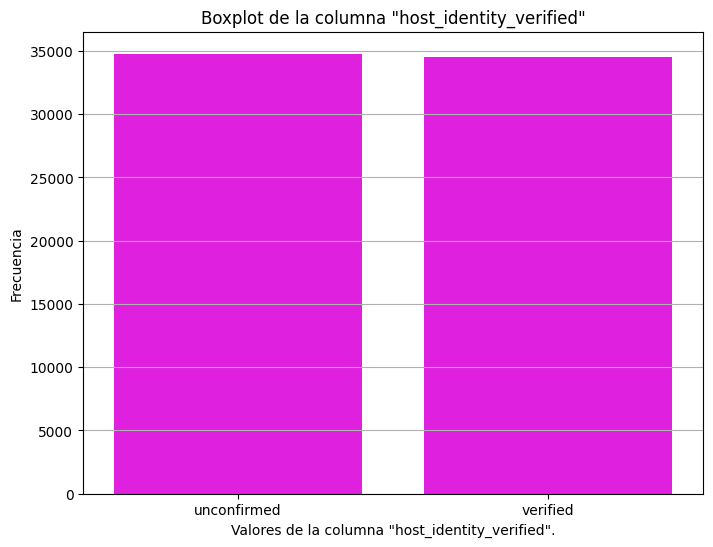

In [72]:
dict = analisis_columna(df,'host_identity_verified', colores='magenta', anchura=8, altura=6)

#### 2.2.2-Columna 'neighbourhood_group'.

<p>Esta columna representa a la distribución de las propiedades en oferta de AirBnB, por distritos de New York City.</p>
<p>Se trata de una variable cualitativa, nominal. Los valores esperables de la variable son los diferentes distritos administrativos en los que se divide la ciudad de New York.</p>
<p>Tal y como se aprecia en la gráfica, las frecuencias de los valores recogidos en la variable presentan una distribución desbalanceada.</p>

********** DATOS DE LA COLUMNA "neighbourhood_group" ********** 

Tipo de datos: object 

Valores nulos: 0 

Valores únicos: 5 

Frecuencia de valores: neighbourhood_group
Manhattan        29587
Brooklyn         27895
Queens            9262
Bronx             1912
Staten Island      649
Name: count, dtype: int64 

La columna "neighbourhood_group" no tiene valores 0. 

Moda: Manhattan

 ***************************** FIN *****************************


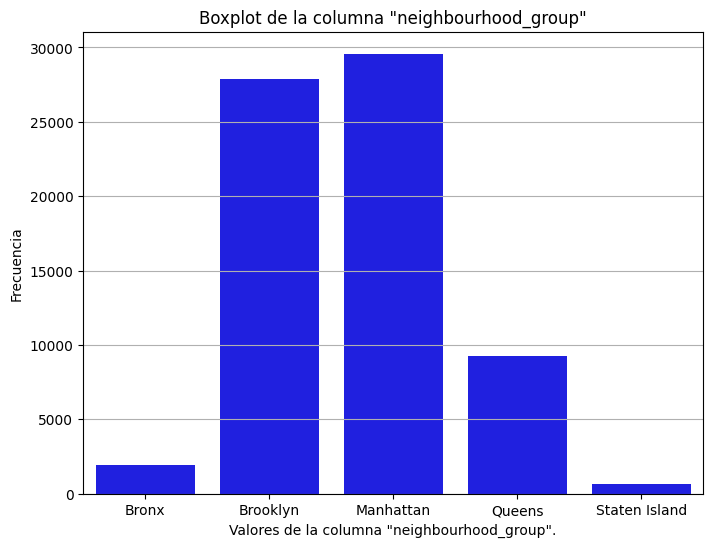

In [73]:
dict = analisis_columna(df,'neighbourhood_group', anchura=8, altura=6)

#### 2.2.3-Columna 'neighbourhood'.

********** DATOS DE LA COLUMNA "neighbourhood" ********** 

Tipo de datos: object 

Valores nulos: 0 

Valores únicos: 239 

Frecuencia de valores: neighbourhood
Bedford-Stuyvesant        5331
Williamsburg              5079
Harlem                    3659
Bushwick                  3270
Hell's Kitchen            2817
                          ... 
Manhattan Avenue             1
Driggs Avenue                1
East 14th Street             1
Fort Wadsworth               1
Chelsea, Staten Island       1
Name: count, Length: 239, dtype: int64 

La columna "neighbourhood" no tiene valores 0. 

Moda: Bedford-Stuyvesant

 ************************** FIN **************************


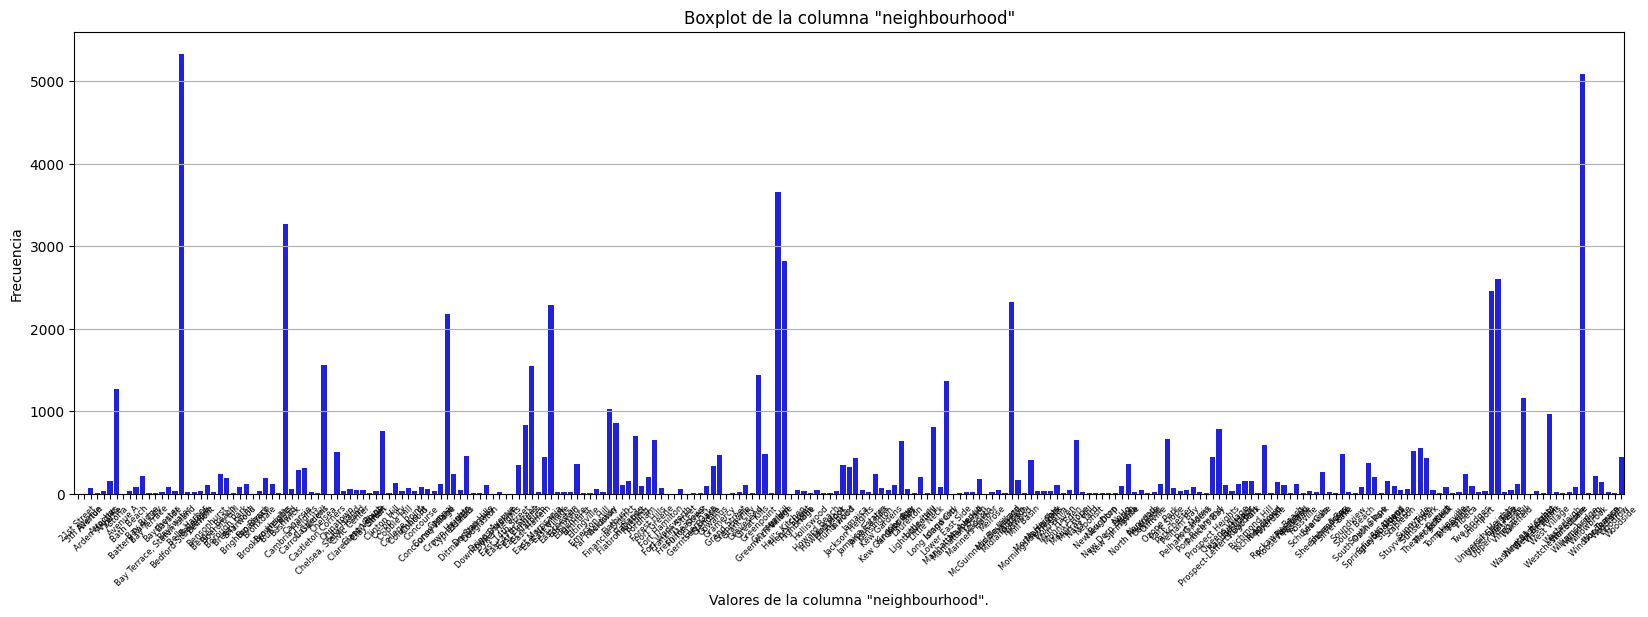

In [76]:
dict = analisis_columna(df,'neighbourhood', anchura=20, altura= 6, texto_x=6, rotacion_x=45)

#### 2.2.4-Columna 'lat'.

In [ ]:
dict = analisis_columna(df,'lat')

#### 2.2.5-Columna 'long'.

In [ ]:
dict = analisis_columna(df,'long')

#### 2.2.6-Columna 'instant_bookable'.

In [ ]:
dict = analisis_columna(df,'instant_bookable')

#### 2.2.7-Columna 'cancellation_policy'.

In [ ]:
dict = analisis_columna(df,'cancellation_policy')

#### 2.2.8-Columna 'room_type'.

In [ ]:
dict = analisis_columna(df,'room_type')

#### 2.2.9-Columna 'construction_year'.

In [ ]:
dict = analisis_columna(df,'construction_year')

#### 2.2.10-Columna 'price'.

In [ ]:
dict = analisis_columna(df,'price')

#### 2.2.11-Columna 'service_fee'.

In [ ]:
dict = analisis_columna(df,'service_fee')

#### 2.2.12-Columna 'minimum_nights'.

In [ ]:
dict = analisis_columna(df,'minimum_nights')

#### 2.2.13-Columna 'number_of_reviews'.

In [ ]:
dict = analisis_columna(df,'number_of_reviews')

#### 2.2.14-Columna 'last_review'.

In [ ]:
dict = analisis_columna(df,'last_review')

#### 2.2.15-Columna 'reviews_per_month'.

In [ ]:
dict = analisis_columna(df,'reviews_per_month')

#### 2.2.16-Columna 'review_rate_number'.

In [ ]:
dict = analisis_columna(df,'review_rate_number')

#### 2.2.17-Columna 'calculated_host_listings_count'.

In [ ]:
dict = analisis_columna(df,'calculated_host_listings_count')

#### 2.2.18-Columna 'availability_365'.

In [ ]:
dict = analisis_columna(df,'availability_365')

#### 2.2.19-Columna 'house_rules'.

In [ ]:
dict = analisis_columna(df,'house_rules')

### 2.2-Análisis Univariante.

#### 2.2.1-Histograma y Boxplot de columnas numéricas.

In [ ]:

sns.set_style("whitegrid") # Se establece el estilo de los gráficos.

# Definir columnas numéricas y categóricas
num_cols = df.select_dtypes(include=['number']).columns.to_list()
cat_cols = df.select_dtypes(exclude=['number']).columns.to_list()

# Crear gráficos univariantes
fig, axes = plt.subplots(len(num_cols), 2, figsize=(15, 20))

for i, col in enumerate(num_cols):
    # Histograma
    sns.histplot(df[col], bins=30, ax=axes[i, 0], kde=True)
    axes[i, 0].set_title(f'Histograma de "{col}"')
    
    # Boxplot
    sns.boxplot(x=df[col], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot de "{col}"')

plt.tight_layout()
plt.show()

#### 2.2.2-Histograma y Boxplot de columnas categóricas.

In [ ]:
fig, axes = plt.subplots(len(cat_cols), 1, figsize=(10, 8))

for i, col in enumerate(cat_cols):
    sns.countplot(x=df[col], order=df[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f'Conteo de {col}')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show();

### 2.3-Análisis Bivariante.

In [ ]:
# Crear scatterplots para ver la relación entre price y otras variables numéricas
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, col in enumerate(num_cols):
    if col != 'price':  # No queremos comparar price con price
        sns.scatterplot(x=df[col], y=df['price'], ax=axes[i//2, i%2])
        axes[i//2, i%2].set_title(f'Scatterplot: {col} vs Price')

plt.tight_layout()
plt.show()


### 2.4-Análisis Multivariante.

In [ ]:
# Matriz de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="viridis", fmt=".2f")
plt.title("Heatmap de Correlaciones")
plt.show();


In [ ]:
sns.pairplot(df, vars=num_cols, hue='room_type', diag_kind="kde", palette="muted")
plt.show();

## 3-MODELADO DE DATOS.

### 3.1-PRE-PROCESAMIENTO.

#### 3.1.1-Variables Numéricas.

##### 3.1.1.1-Imputer.

'reviews_per_month' tenía valores nulos → se imputan con la media.

In [ ]:
# Imputar valores nulos en 'reviews_per_month' con la media
imputer = SimpleImputer(strategy='mean')
df['reviews_per_month'] = imputer.fit_transform(df[['reviews_per_month']])

##### 3.1.1.2-Scaler.

* Escalado de variables numéricas.

Se usa StandardScaler para estandarizar los datos (media 0, desviación estándar 1).
Esto ayuda a que modelos como regresión y clustering trabajen mejor.

In [ ]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


##### 3.1.1.3-Transformer.

Se usa OneHotEncoder para convertir variables categóricas en variables dummy.
Se usa drop='first' para evitar colinealidad.

In [ ]:
# Columnas categóricas
#cat_cols = ['neighbourhood_group', 'neighbourhood', 'room_type']

# Aplicar OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_data = encoder.fit_transform(df[cat_cols])

# Convertir a DataFrame y agregar al dataset
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(cat_cols))
df_final = pd.concat([df.drop(columns=cat_cols), encoded_df], axis=1)


#### 3.1.2-Variables Categóricas.

##### 3.1.2.1-Imputer.

##### 3.1.2.2-Encoder.

### 3.2-CLUSTERING Y SILUETAS.

### 3.3-SELECCIÓN DE COLUMNAS (FEATURING SELECTION).

### 3.3-PREDICCIONES.

#### 3.3.1-Regresiones.

#### 3.3.2-Clasificaciones (multiclase).

### 3.4-COMPARACIÓN DE RESULTADOS: VALIDACIÓN CRUZADA.